# Qini curves with multiple costly treatment arms

This notebook shows approaches to evaluating multi-armed CATE estimators from `causalML` with the Multi-Armed Qini metric available in the `maq` package (available at https://github.com/grf-labs/maq).


This metric is a generalization of the familiar *Qini curve* to settings where we have multiple treatment arms available, and the cost of assigning treatment can vary by both unit and treatment arm according to some known cost structure. At a high level, this metric essentially allows you to quantify the value of targeting with more treatment arms by undertaking a cost-benefit exercise that uses your CATE estimates to assign the arm to the unit that is most cost-beneficial at various budget constraints.

This notebook gives a brief overview of the statistical setup and a walkthrough with a simple simulated example. 


To use this functionality, you first have to install the `maq` Python package from GitHub. The latest source release can be installed with:

```
pip install "git+https://github.com/grf-labs/maq.git#egg=maq&subdirectory=python-package"
```

In [2]:
# Treatment effect estimators (R-learner with Causal ML + XGBoost)
from causalml.inference.meta import BaseRRegressor
from xgboost import XGBRFRegressor

# Generalized Qini curves
from maq import MAQ, get_ipw_scores

import numpy as np
np.random.seed(42)

## Statistical setup

Let $k = 1, \ldots K$ denote one of $K$ mutually exclusive and costly treatment arms and $k = 0$ a (costless) control arm.  Let $Y_i(k)$ denote the potential outcome in the $k$-th arm for unit i, and $X_i$ a set of observable characteristics.

Let the function $\hat \tau(\cdot)$ be an estimate of the conditional average treatment effect (CATE) obtained from a training set, where the $k$-th element estimates
$$
\tau_k(X_i) = E[Y_i(k) - Y(0) ~|~ X_i].
$$

The Qini curve $Q(B)$ quantifies the value of assigning treatment in accordance with our estimated function $\hat \tau(\cdot)$ over different values of a budget constraint $B$. With a **single treatment arm** $K=1$ we can formalize this as
$$
Q(B) = E[ \pi_B(X_i)\left( Y_i(1) - Y_i(0) )\right] = E[\pi_B(X_i) \tau(X_i)],
$$


where $\pi_B(X_i) \in \{0, 1\}$ is the *policy* that assigns treatment (=1) to those units *predicted* by $\hat \tau(\cdot)$ to benefit the most such that on average we incur a cost of at most B. If we let $C(\cdot)$ denote our known cost function (e.g. $C(X_i) = 4.2$ means assigning the $i$-th unit the treatment costs 4.2 on some chosen cost denomination), then $\pi_B$ is going to look like
$$
\pi_B = argmax_{\pi} \left\{ E[\pi_B(X_i) \hat \tau(X_i)] : E[\pi_B(X_i) C(X_i)] \leq B  \right\}
$$

While slightly daunting written down formally, it turns out expressing $\pi_B$ is quite simple: it essentially reduces to a thresholding rule: for a given $B$, treat the units where the predicted cost-to-benefit ratio $\frac{\hat \tau(X_i)}{C(X_i)}$ is above a cutoff. The  Qini curve can be used to quantify the value, as measured by the expected gain over assigning each unit the control arm when using the estimated function $\hat \tau(\cdot)$ with cost structure $C(\cdot)$ to allocate treatment,
as we vary the available budget $B$.

With **multiple treatment arms** $K > 1$, our object of interest, the Qini curve, is the same, we just need to add an inner product $\langle,\rangle$ to the notation
$$
Q(B) = E[\langle \pi_B(X_i),~ \tau(X_i) \rangle],
$$
to denote that $\pi_B(X_i)$ now is a $K$-length selection vector with 1 in the $k$-th entry if we predict that it is optimal to assign the $i$-th unit that arm at the given budget constraint. Similarly to above, $\pi_B$ takes the following form
$$
\pi_B = argmax_{\pi} \left\{ E[\langle \pi_B(X_i),~ \hat \tau(X_i)\rangle] : E[\langle \pi_B(X_i),~ C(X_i)\rangle] \leq B  \right\}.
$$
Expressing $\pi_B$ is more complicated now, as for each budget constraint $B$, $\pi_B$ has to make decisions of the form "should I assign the $i$-th unit an initial arm, or if the $j$-th unit had already been assigned an arm: should I upgrade this person to a costlier but more effective arm?". It turns out that it is possible to express $\pi_B$ as a thresholding rule (for details we refer to this [paper](https://arxiv.org/abs/2306.11979)), yielding tractable ways to construct Qini curves for multi-armed treatment rules.

## Example

### Fitting a CATE function on a training set

Generate some simple (synthetic) data with $K=2$ treatment arms, where the second arm is more effective on average.

In [3]:
n = 20000
p = 5

# Draw a treatment assignment from {0, 1, 2} uniformly
W = np.random.choice([0, 1, 2], n)
# Generate p observable characteristics where some are related to the CATE
X = np.random.rand(n, p)
Y = X[:, 1] + X[:, 2]*(W == 1) + 1.5*X[:, 3]*(W == 2) + np.random.randn(n)
# (in this example, the true arm 2 CATE is 1.5*X[:, 3])

# Generate a train/test split
n_train = 15000
ix = np.random.permutation(n)
train, test = ix[:n_train], ix[n_train:]

Obtain $\hat \tau(\cdot)$ by fitting a CATE estimator on the training set (using an *R-learner*, for example).


In [4]:
# Use known propensities (1/3)
W_hat = np.repeat(1 / 3, n_train)
propensities = {0: W_hat, 1: W_hat, 2: W_hat}

tau_function = BaseRRegressor(XGBRFRegressor(), random_state=42)
tau_function.fit(X[train, :], W[train], Y[train], propensities)

### Estimating Q(B) on a test set

At a high level, there are two tasks associated with estimating a Qini curve $Q(B)$. The first one is estimating the underlying policy $\pi_B$, and the second is estimating the value of this policy.

As mentioned in the previous section, with multiple costly treatment arms, the policy $\pi_B$ is more complicated to compute than in the single-armed case, since given a treatment effect function (obtained from some training set) and a cost structure, we need to figure out which arm to assign to which unit at every budget constraint. The maq package performs this *first* step with an algorithm that gives the path of multi-armed policies $\pi_B$.

For the *second* step of estimating the value of this policy, we need to construct a matrix of suitable evaluation *scores* (that we denote by $\Gamma$) that have the property that when averaged they act as treatment effect estimates.

If we know the treatment randomization probabilities $P[W_i=k~|~X_i]$, it turns out that constructing these scores is easy: we can simply use inverse-propensity weighting (IPW). With $K$ treatment arms, the scores for the $k$-th arm
then takes the following form

$$
\Gamma_{i,k} = \frac{1(W_i=k)Y_i}{P[W_i=k~|~X_i]} - \frac{1(W_i=0)Y_i}{P[W_i=0~|~X_i]},
$$

where $W_i$ and $Y_i$ are the treatment assignment and observed outcome for test set unit i. An estimate of the ATE for the $k$-th arm is given by the average of these scores: $\frac{1}{n_{test}} \sum_{i=1}^{n_{test}} \Gamma_{i,k}$. An IPW-based estimate of $Q(B)$ is going to be an average of these scores that "matches" the underlying policy prescription $\pi_B$.

the `maq` package has a simple convenience utility `get_ipw_scores` that can be used to construct these via IPW (which by default assumes the arms have uniform assignment probabilities $\frac{1}{K+1}$).

*Note*: if the randomization probabilities are not known (as could be the case in an observational setting), then a more robust alternative to form the scores via plugging in estimates of the propensities into the expression above, is to use augmented inverse-propensity weighting (AIPW), yielding a doubly robust estimate of the Qini curve. This approach is not covered here, for details we refer to the [paper](https://arxiv.org/abs/2306.11979).


In [5]:
# Construct an n_test*K matrix of evaluation scores 
IPW_scores = get_ipw_scores(Y[test], W[test])

# Predict CATEs on the test set
tau_hat = tau_function.predict(X[test, :])

# Specify our cost structure, 
# assume the cost of assigning each unit the first arm is 0.2
# and the cost of assigning each unit the second more effective arm is 0.5
# (these can also be array-valued if costs vary by unit)
cost = [0.2, 0.5]

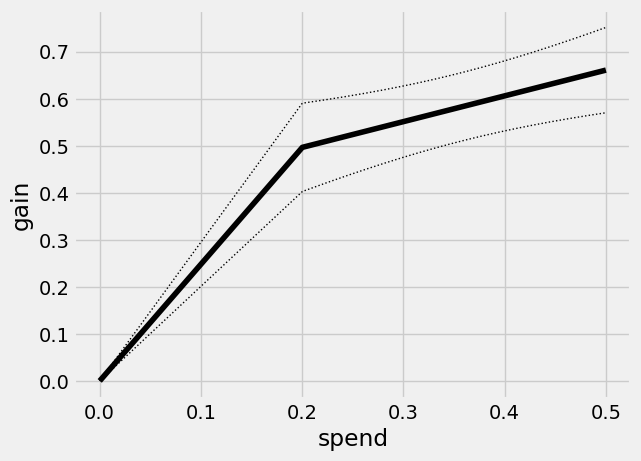

In [6]:
# Start by fitting a baseline Qini curve that only considers the average treatment effects and costs
qini_baseline = MAQ(target_with_covariates=False, n_bootstrap=200)
qini_baseline.fit(tau_hat, cost, IPW_scores)

qini_baseline.plot()

This curve has a kink at $B=0.2$: the first segment traces out the ATE of the lower cost arm, and the second segment the ATE of the higher cost but on average more effective arm. Points on this curve represents the average benefit per unit when targeting an arbitrary group of units.

For example, at an average spend of 0.2 our gain (along with standard errors) is equal to the arm 1 ATE of

In [7]:
qini_baseline.average_gain(0.2)

(0.49665725358631685, 0.047913821952266705)

Next, we fit a Qini curve for arm 1

In [8]:
tau_hat_1 = tau_hat[:, 0]
cost_1 = cost[0]
IPW_scores_1 = IPW_scores[:, 0]

qini_1 = MAQ(n_bootstrap=200).fit(tau_hat_1, cost_1, IPW_scores_1)

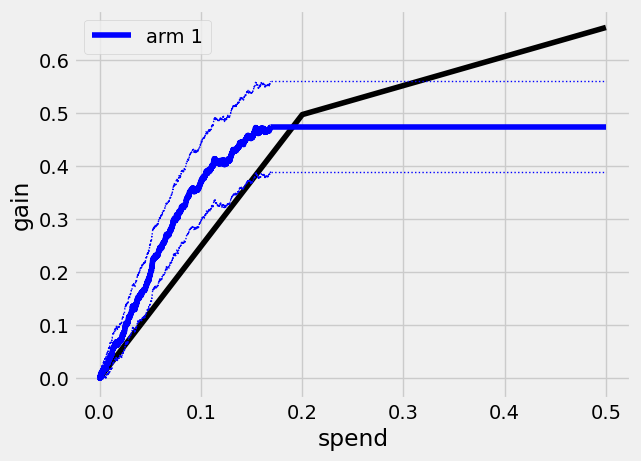

In [9]:
qini_baseline.plot(show_ci=False)
# Plot curve with 95% confidence bars
qini_1.plot(color="blue", label="arm 1")


The Qini curve for this arm plateaus at a spend of around

In [10]:
print(qini_1.path_spend_[-1])

0.168840000000009


which means that at this spend level we have given treatment to all units predicted to benefit from treatment (that is, `tau_hat_1` is > 0). We can read off estimates and std errors from the curve, for example at a spend of $B=0.1$ per unit, the estimated average treatment effect per unit is

In [11]:
qini_1.average_gain(0.1)

(0.36935574662263526, 0.037401976389534526)

(these standard errors are conditional on the estimated function $\hat \tau(\cdot)$ and quantify test set uncertainty in estimating the Qini curve).

We can assess the value of targeting with arm 1 at various spend levels by estimating the vertical difference between the blue and black line. Let's call the Qini curve for arm 1 $Q_1(B)$ and the Qini curve for the baseline policy $\overline Q(B)$. At $B=0.1$, an estimate of $Q_1(0.1) - \overline Q(0.1)$ is

In [12]:
est, std_err = qini_1.difference_gain(qini_baseline, 0.1)
est, std_err

(0.12102711982945671, 0.024068445449392815)

That is, at a budget of 0.1 per unit a 95% confidence interval for the increase in gain when targeting with the given arm 1 CATE function over random targeting is

In [13]:
[est - 1.96*std_err, est + 1.96*std_err]

[0.0738529667486468, 0.16820127291026662]

(points on aribtrary curves can be compared with the `difference_gain` method, yielding paired standard errors that account for the correlation between Qini curves fit on the same test data).

Similarily, we can estimate a Qini curve $Q_2(B)$ for the second costlier arm

In [14]:
tau_hat_2 = tau_hat[:, 1]
cost_2 = cost[1]
IPW_scores_2 = IPW_scores[:, 1]

qini_2 = MAQ(n_bootstrap=200).fit(tau_hat_2, cost_2, IPW_scores_2)

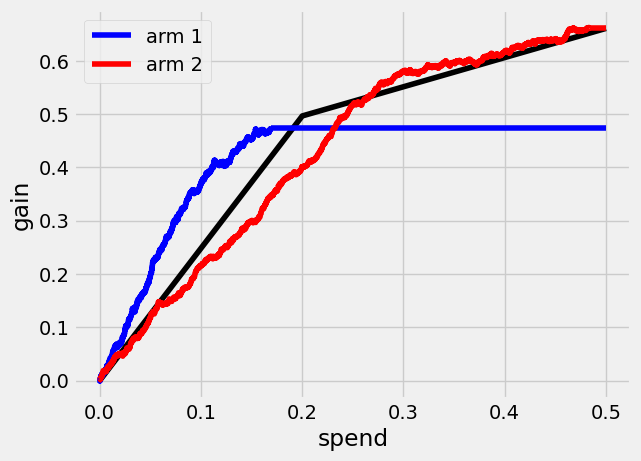

In [15]:
qini_baseline.plot(show_ci=False) # Leave out CIs for legibility
qini_1.plot(color="blue", label="arm 1", show_ci=False)
qini_2.plot(color="red", label="arm 2", show_ci=False)

Finally, we can see what a Qini curve $Q(B)$ using both arms looks like.

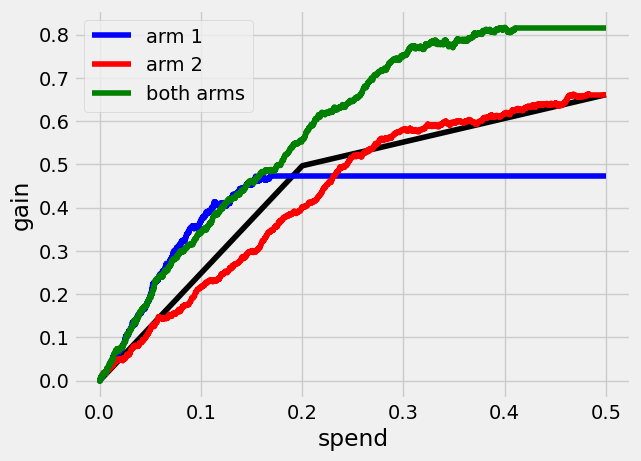

In [16]:
qini_ma = MAQ(n_bootstrap=200).fit(tau_hat, cost, IPW_scores)

qini_baseline.plot(show_ci=False)
qini_1.plot(color="blue", label="arm 1", show_ci=False)
qini_2.plot(color="red", label="arm 2", show_ci=False)
qini_ma.plot(color="green", label="both arms", show_ci=False)

Qini curves for single-armed treatment rules allow for assessing the value of targeting with a specific arm or targeting function. The generalization of the Qini to multiple treatment arms allows us to also assess the value of targeting with a combination of arms.

At $B=0.3$, the estimated increase in gain when targeting with both arms over using only the second arm, $Q(0.3) - Q_2(0.3)$, is

In [17]:
qini_ma.difference_gain(qini_2, 0.3)

(0.17003364056661086, 0.036733311977033105)

In this example, a multi-armed policy achieves a larger gain by assigning the treatment that is most cost-beneficial to each test set unit. The underlying policy $\pi_B$ looks like

In [18]:
qini_ma.predict(0.3)

array([[0., 1.],
       [0., 1.],
       [1., 0.],
       ...,
       [1., 0.],
       [0., 1.],
       [0., 1.]])

where rows correspond to $\pi_B(X_i)$, where the $k$-th column contains a 1 if it is optimal to assign this arm to the $i$-th unit at the given spend (and all entries 0 if the control arm is assigned). An alternative representation of the policy is to take values in the treatment arm set {0, 1, 2}

In [19]:
qini_ma.predict(0.3, prediction_type="vector")

array([2, 2, 1, ..., 1, 2, 2])

In addition to comparing points on different Qini curves, we can also compare across a range of spend levels by estimating an area between two curves up to a maximum $\overline B$. An estimate and standard error of the area between the green and red curves up to $\overline B=0.5$, the integral $\int_{0}^{0.5} (Q(B) - Q_2(B))dB$, is

In [20]:
qini_ma.integrated_difference(qini_2, 0.5)

(0.12548196750671803, 0.02945344768121884)